# time series forecasting

In [1]:
!pip install statsforecast utilsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.6/354.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.5/280.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


## dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive, AutoARIMA

import warnings
warnings.filterwarnings("ignore")

## dataset

In [3]:
data = pd.read_csv("/content/daily_sales_french_bakery.csv", parse_dates=["ds"])
data.head(10)

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0
5,12 MACARON,2022-07-18,0.0,10.0
6,12 MACARON,2022-07-19,10.0,10.0
7,12 MACARON,2022-07-20,0.0,10.0
8,12 MACARON,2022-07-21,10.0,10.0
9,12 MACARON,2022-07-22,0.0,10.0


In [4]:
data.shape

(57046, 4)

In [5]:
data["unique_id"].value_counts()

,count
unique_id,
BAGUETTE,637
BOULE 200G,637
BANETTE,637
BANETTINE,637
BRIOCHE,637
...,...
PLAT 6.50E,1
SACHET DE VIENNOISERIE,1
TARTELETTE COCKTAIL,1


In [6]:
data = data.groupby("unique_id").filter(lambda x: len(x) >= 28)
data = data.drop("unit_price", axis=1)
data.head(10)

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0
5,12 MACARON,2022-07-18,0.0
6,12 MACARON,2022-07-19,10.0
7,12 MACARON,2022-07-20,0.0
8,12 MACARON,2022-07-21,10.0
9,12 MACARON,2022-07-22,0.0


In [7]:
data.shape

(56904, 3)

In [8]:
data["unique_id"].value_counts()

,count
unique_id,
BAGUETTE,637
BOULE 400G,637
BANETTE,637
BOULE 200G,637
BANETTINE,637
...,...
RELIGIEUSE,71
SABLE F P,68
DELICETROPICAL,63


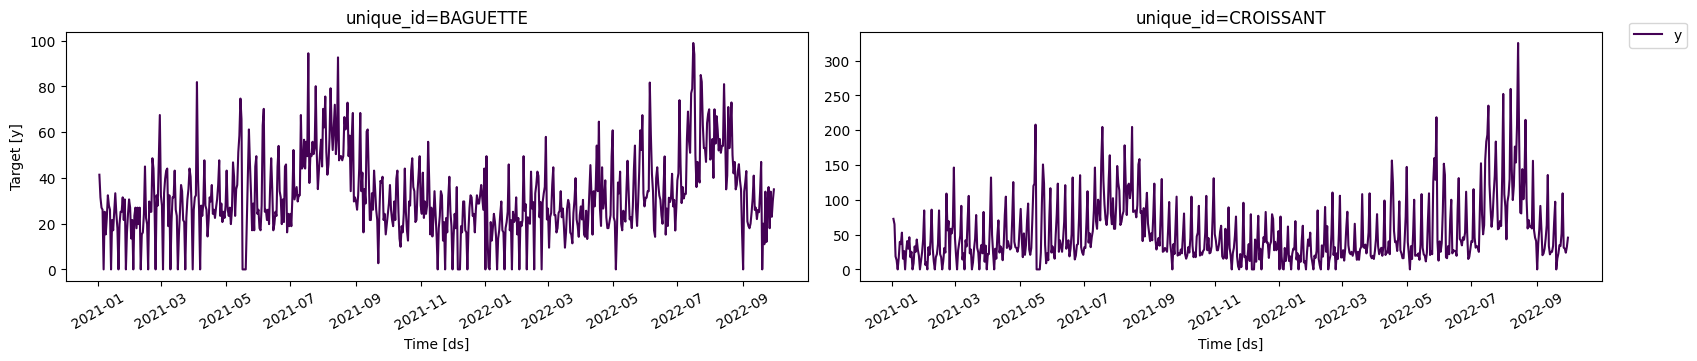

In [9]:
plot_series(
    df = data,
    ids = ["BAGUETTE", "CROISSANT"],
    palette = "viridis"
)

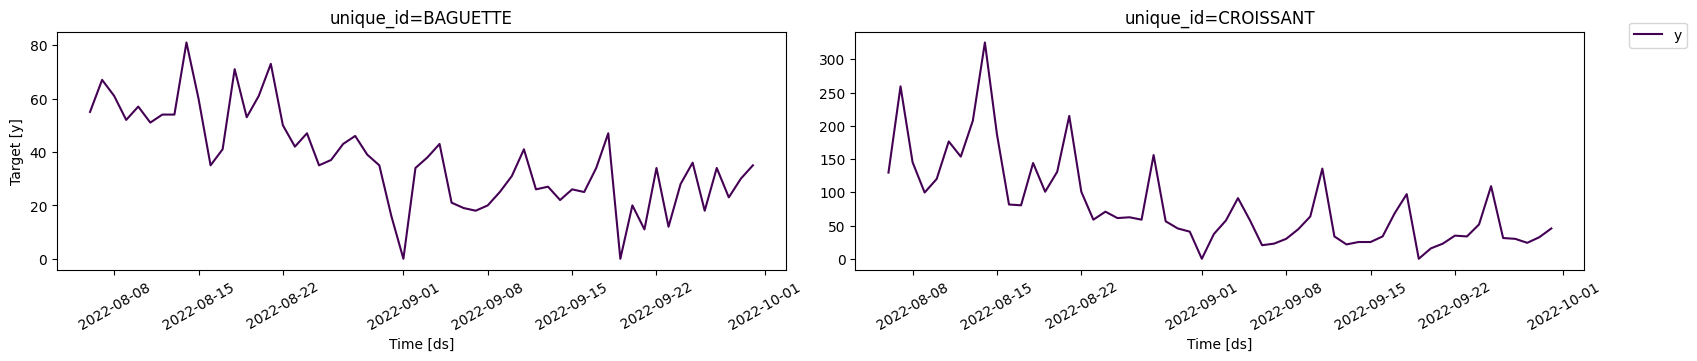

In [10]:
plot_series(
    df = data,
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 56,
    palette = "viridis"
)

## base models

In [11]:
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(
    models = models,
    freq = "D"
)
sf.fit(df = data)
preds = sf.predict(h=horizon)

In [12]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


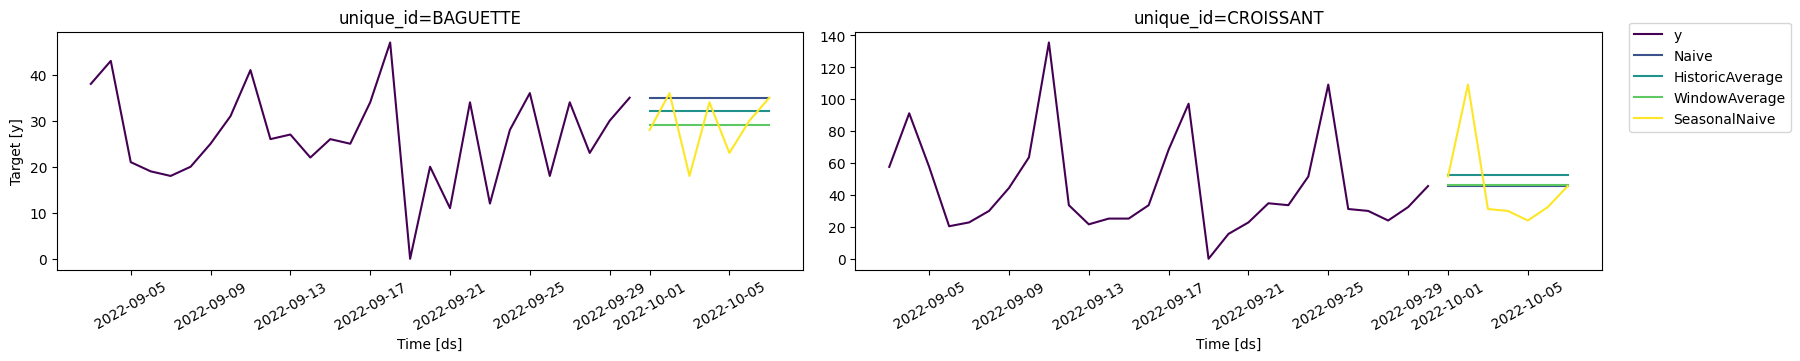

In [13]:
plot_series(
    df = data,
    forecasts_df = preds,
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 28,
    palette = "viridis"
)

In [14]:
test = data.groupby("unique_id").tail(7)
train = data.drop(test.index).reset_index(drop=True)

In [15]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(
    test,
    preds,
    "left",
    ["ds", "unique_id"]
)

In [16]:
evaluation = evaluate(
    eval_df,
    metrics = [mae]
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [17]:
evaluation = evaluation.drop("unique_id", axis=1).groupby("metric").mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


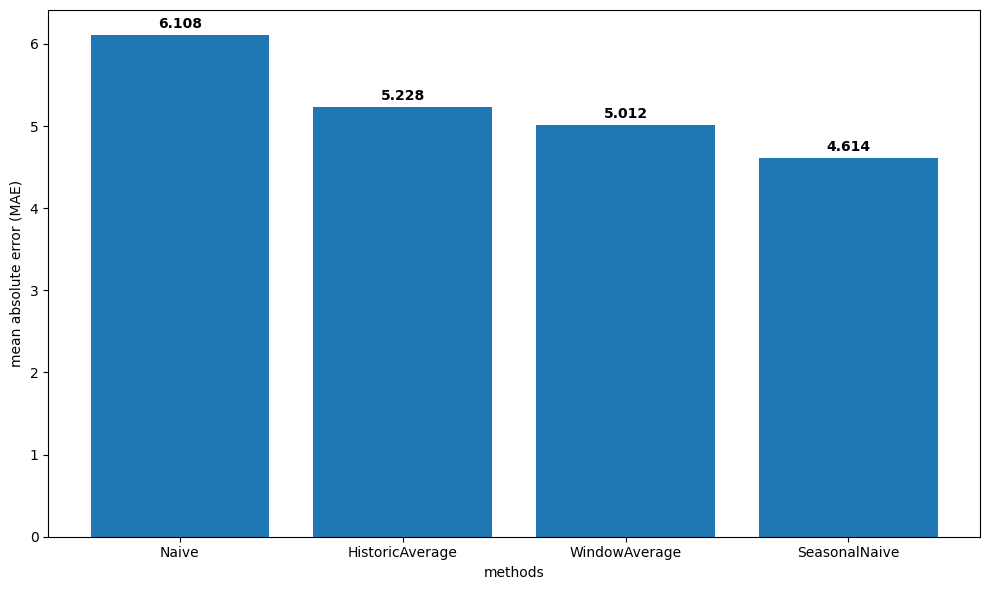

In [18]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0, 1:].tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
  plt.text(
      bar.get_x() + bar.get_width()/2,
      bar.get_height() + 0.05,
      f"{value:.3f}",
      ha = "center",
      va = "bottom",
      fontweight = "bold"
  )

plt.xlabel("methods")
plt.ylabel("mean absolute error (MAE)")
plt.tight_layout()
plt.show()

## AutoARIMA

In [19]:
unique_ids = ["BAGUETTE", "CROISSANT"]

small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(
    arima_preds,
    eval_df,
    "inner",
    ["ds", "unique_id"]
)

arima_eval = evaluate(
    arima_eval_df,
    metrics = [mae]
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [20]:
arima_eval = arima_eval.drop("unique_id", axis=1).groupby("metric").mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


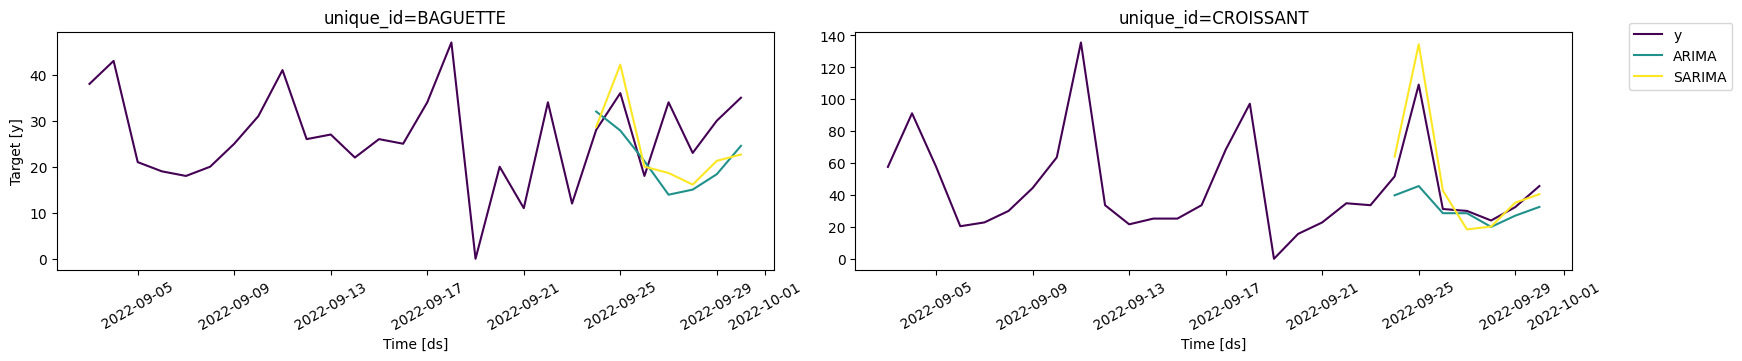

In [21]:
plot_series(
    df = data,
    forecasts_df = arima_preds,
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 28,
    palette = "viridis"
)

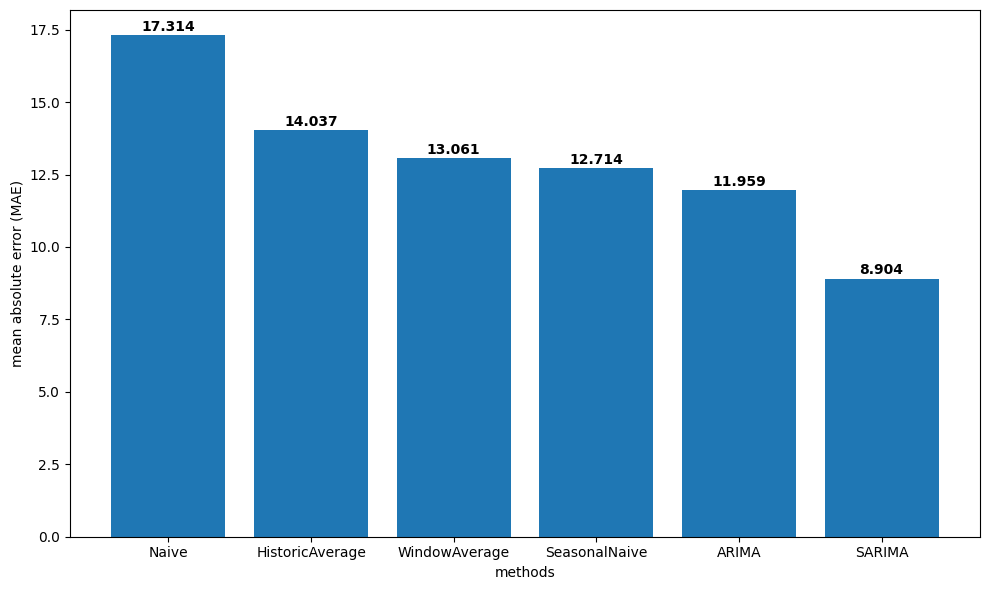

In [23]:
methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[0, 1:].tolist()

sorted_data = sorted(
    zip(methods, values),
    key = lambda x: x[1],
    reverse = True
)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
  plt.text(
      bar.get_x() + bar.get_width()/2,
      bar.get_height() + 0.05,
      f"{value:.3f}",
      ha = "center",
      va = "bottom",
      fontweight = "bold"
  )

plt.xlabel("methods")
plt.ylabel("mean absolute error (MAE)")
plt.tight_layout()
plt.show()